In [60]:
import numpy as np
from my_disp import Dispersion_Analysis as Disp
import scipy.constants as const
import matplotlib.pyplot as plt


class LLETest:
    def __init__(self, **kwargs):
        self.res = kwargs.get('res', {})
        self.sim = kwargs.get('sim', {})

        # print(self.res)
        # print(self.sim)

        self.debug = kwargs.get('debug', False)
        if not 'D1_manual' in self.sim.keys():
            self.res['D1_manual'] = None
        if not 'f_pmp' in self.sim.keys():
            self.res['f_pmp'] = const.c/self.res['lambda_pmp']
        if not 'mu_fit' in self.sim.keys():
            self.res['mu_fit'] = [None, None]
        if not 'num_probe' in self.sim.keys():
            self.res['num_probe'] = 1000

        if not np.diff(self.sim['mu_sim'])[0] % 2 ==0:
            print('Simulated number of modes needs to be odd')
            self.sim['mu_sim'] = [self.sim['mu_sim'][0], self.sim['mu_sim'][1]+1]
            print('Changing to', self.sim['mu_sim'])

        if not 'del_omega' in self.sim.keys():
            self.sim['del_omega'] = [0]*len(self.sim['f_pmp'])
            self.sim['ind_pmp_sweep'] = 0
        else:
            del_omega = self.sim['del_omega']
            id_sweep = [ii for ii in range(len(del_omega)) if del_omega[ii] == None]
            assert (
                len(id_sweep) >= 1
            ), "Need to provide at least None possition in domega to determine which pump is swept"

            self.sim["ind_pump_sweep"] = id_sweep
        
        assert len(self.sim['f_pmp']) == len(self.sim['del_omega']), "Please provide the same number of pump fixed detuning than pump power. Detuning = None for the pump which is swept"
        if not type(self.sim["ind_pump_sweep"]) == list:
            self.sim["ind_pump_sweep"] = [self._sim["ind_pump_sweep"]]
            
        if not "phi_pmp" in self.sim.keys():
            self.sim["phi_pmp"] = [0] * len(self.sim["f_pmp"])
        else:
            if not type(self.sim["phi_pmp"]) == list:
                self.sim["phi_pmp"] = [self.sim["phi_pmp"]]
        assert len(self.sim["f_pmp"]) == len(
            self.sim["phi_pmp"]
        ), "Please provide the same number of pump phase than pump frequencies. Detuning = None for the pump which is swept"
        
    def analyze(self):

        self._analyze = Disp(disp_file=self.res['disp_file'], R=self.res['R'],\
                              f_pmp=self.sim['f_pmp'], D1_manual=self.sim['D1_manual'],\
                                  rM_fit=self.sim['mu_fit'], rM_sim=self.sim['mu_sim'],\
                                      debug=self.debug)
        self._analyze.getDint()
        # self._analyze.display_params()
        fig = self._analyze.plot_dispersion()

        self.sim['Dint'] = self._analyze.Dint_sim[0]
        self.sim['D1'] = self._analyze.D1[0]
        self.res['ng'] = self._analyze.ng_pmp
        self.sim['ind_pmp'] = self._analyze.pmp_ind
        self.sim['f_center'] = self._analyze.f_pmp[-1]
        self.sim['f_pmp'] = self._analyze.f_pmp[:-1]
        self.sim['mu_sim_center'] = [
            self.sim['mu_sim'][0] + self.sim['ind_pmp'][0],
            self.sim['mu_sim'][1] + self.sim['ind_pmp'][0]
        ]
        self.sim['D1_center'] = self._analyze.D1[-1]
        self.sim['FSR'] = [dd/(2*np.pi) for dd in self._analyze.D1[:-1]]
        self.sim['FSR_center'] = self._analyze.D1[-1]/(2*np.pi)

        if not 'DKS_init' in self.sim.keys():
            self.sim['DKS_init'] = np.zeros(self._analyze.Dint_sim[0].size)
        
        self.Disp = {
            "ng": self._analyze.ng,
            "D": self._analyze.D * 1e6,
            "D1": self._analyze.D1[0],
            "neff": self._analyze.n_eff,
            "freq": self._analyze.rf,
            "freq_sim": self._analyze.freq_fit,
            "Dint": self._analyze.Dint[:-1],
            "Dint_sim": self._analyze.Dint_sim[:-1],
            "Dint0": self._analyze.Dint_sim[-1],
            "FSR": self.sim["FSR"],
            "FSR_center": self.sim["FSR_center"],
        }

        self.Res = {
            'R': self.res['R'],
            'Qi': self.res['Qi'],
            'Qc': self.res['Qc'],
            'gamma': self.res['gamma'],
            'dispfile': self.res['disp_file']
        }

        self.Sim = {
            'Pin': self.sim['Pin'],
            'Tscan': self.sim['Tscan'],
            'f_pmp': self.sim['f_pmp'],
            'f_center': self.sim['f_center'],
            'del_omega_init': self.sim['del_omega_init'],
            'del_omega_end': self.sim['del_omega_end'],
            'del_omega': self.sim['del_omega'],
            'mu_sim': self.sim['mu_sim'],
            'mu_fit': self.sim['mu_fit'],
            'mu_sim_center': int(-1*self.sim['mu_sim_center'][0]),
            'ind_pmp': self.sim['ind_pmp'],
            'num_probe': self.sim['num_probe'],
            'DKS_init': self.sim['DKS_init'],
            'phi_pmp': self.sim['phi_pmp'],
            'ind_pmp_sweep': self.sim['ind_pump_sweep']
        }
    
    def calc_lle_params(self):
        self.beta_2 = self._analyze.beta_2
        self.Pin = self.Sim['Pin']
        self.gamma = self.Res['gamma']
        self.L = 2*np.pi*self.Res['R']
        self.omega_0 = self.sim['f_pmp'][0]*2*np.pi
        self.Q0 = self.Res['Qi']
        self.Qc = self.Res['Qc']
        self.tR = self.L*self.res['ng']/const.c
        self.alpha = (1/2)*(1/self.Q0 + 1/self.Qc)*self.omega_0*self.tR
        theta = self.omega_0*self.tR/self.Qc
        # del_omega = -1*np.array(self.sim['del_omega'])*tR
        self.nlc = -1j*self.gamma*self.L
        self.mu = np.arange(self.sim['mu_sim'][0], self.sim['mu_sim'][1]+1)
        self.pmp_ind = np.where(self.mu == 0)[0][0]
        self.omega = self.mu * 2*np.pi/self.tR + self.omega_0
        self.nu = self.omega/(2*np.pi)
        self.E_in = np.zeros(self.mu.size)
        self.E_in[self.pmp_ind] = np.sqrt(self.Pin)*self.mu.size
        self.E_in_couple = np.sqrt(theta)*self.E_in

        self.mu0 = int((len(self.mu) - 1) / 2)  # center of the domain
        self.Dint_centered = self._analyze.Dint_sim[0] - self._analyze.Dint_sim[0][self.mu0]

        plt.figure()
        plt.plot(self.nu*1e-12, np.abs(self.E_in)**2, label='Pump')
        plt.xlabel('Frequency (THz)')
        plt.ylabel('Power (W)')
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(self.nu*1e-12, np.abs(self.E_in_couple)**2, label='Coupled')
        plt.xlabel('Frequency (THz)')
        plt.ylabel('Power (W)')
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(self.nu*1e-12,np.abs(self.Dint_centered)*1e-9, label='Dint')
        plt.xlabel('Frequency (THz)')
        plt.ylabel('Dint (GHz)')
        plt.legend()
        plt.show()
    
    def get_lle_params(self):
        self.calc_lle_params()
        params = {
            'tR': self.tR,
            'alpha': self.alpha,
            'delta_0': self.omega_0 - 1e9*2*np.pi,
            'Dint': self.Dint_centered,
            'gamma': self.gamma,
            'theta': self.omega_0 * self.tR / self.Res['Qc'],
            'E_in': self.E_in_couple
        }
        return params
        

-----------------------------------


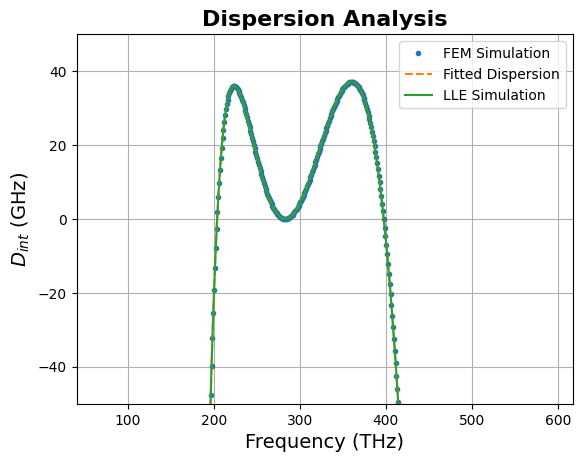

C:\Users\viswa\AppData\Local\Temp\ipykernel_16120\3003677682.py:140: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.E_in[self.pmp_ind] = np.sqrt(self.Pin)*self.mu.size


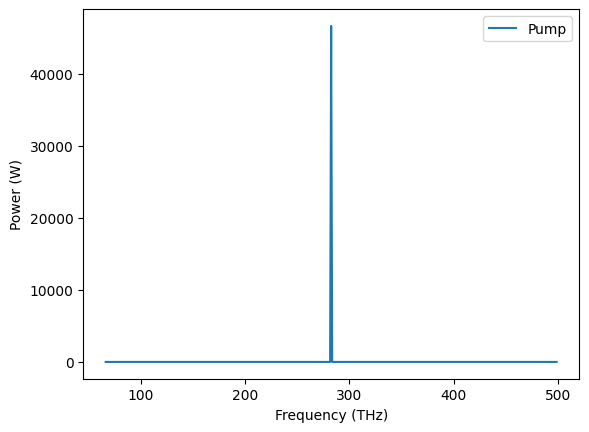

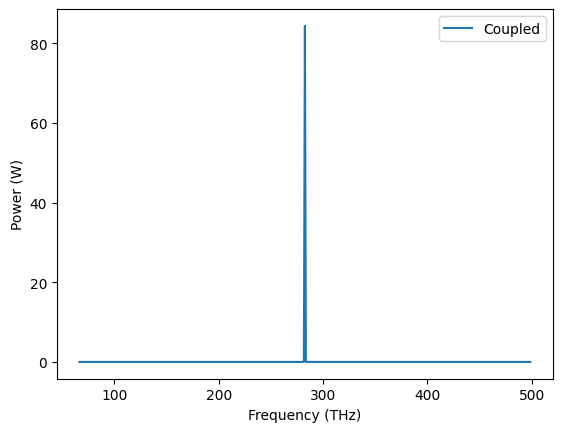

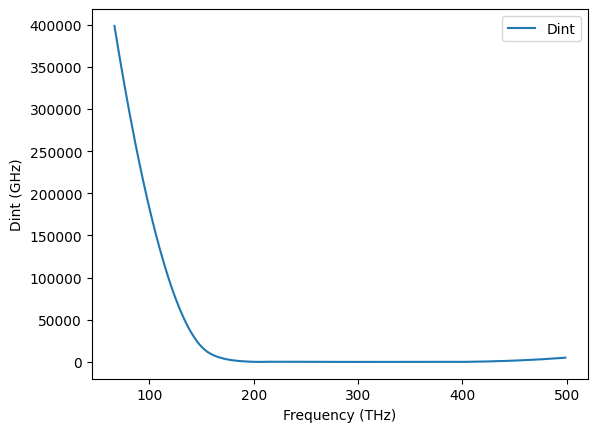

In [61]:
res = dict(
        R=23e-6, 
        Qi=1e6, 
        Qc=1e6, 
        gamma=3.2, 
        disp_file='RW1000_H430.csv',
)

sim = dict(
    Pin=[240e-3], 
    f_pmp=[283e12],
    phi_pmp=[0], 
    del_omega=[None], 
    Tscan=0.7e6,
    mu_sim=[-220, 220],
    mu_fit=[None, None],
    del_omega_init= 1e9 * 2 * np.pi,
    del_omega_end= -6.5e9 * 2 * np.pi,
    num_probe = 5000, 
    D1_manual = None
)

lle = LLETest(res=res, sim=sim)

lle.analyze()
# print(lle._analyze.pmp_ind_fit)
# print(lle._analyze.FSR)
lle.calc_lle_params()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the neural network
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
        self.activation = nn.Tanh()
    
    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Define the LLE Loss Function
def lle_loss(network, t, tau, params):
    # Unpack parameters
    tR, alpha, delta_0, Dint, gamma, theta, E_in = params['tR'], params['alpha'], params['delta_0'], params['Dint'], params['gamma'], params['theta'], params['E_in']
    
    # Predict the real and imaginary parts of the field
    E_pred = network(torch.cat((t, tau), dim=1))
    E_pred_real = E_pred[:, 0:1]
    E_pred_imag = E_pred[:, 1:2]
    
    # Compute the complex field
    E = E_pred_real + 1j * E_pred_imag
    
    # Fourier Transform with respect to tau
    E_tau = torch.fft.fft(E, dim=1)
    
    # Compute the LLE residual
    E_t = torch.gradient(E, spacing=(t,))
    LHS = tR * E_t
    RHS = -(alpha / 2 - 1j * delta_0) * E \
          + 1j * torch.fft.ifft(-tR * Dint * E_tau, dim=1) \
          + gamma * torch.abs(E)**2 * E \
          + torch.sqrt(theta) * E_in
    
    # Compute the loss
    loss = torch.mean((LHS - RHS).real**2 + (LHS - RHS).imag**2)
    return loss

# Define a function to generate tau and t
def generate_time_axes(tR, TScan, num_points_tau, num_points_t):
    tau = torch.linspace(-tR/2, tR/2, num_points_tau).view(-1, 1)
    t = torch.linspace(0, TScan, num_points_t).view(-1, 1)
    tau, t = torch.meshgrid(tau.squeeze(), t.squeeze())
    return t.flatten().view(-1, 1), tau.flatten().view(-1, 1)

# Initialize the LLETest class
lle_test = LLETest(res=res, sim=sim)
lle_test.analyze()

# Get LLE parameters
lle_params = lle_test.get_lle_params()

# Initialize the network and optimizer
layers = [2, 64, 64, 64, 2]  # Example architecture; modify as needed
network = PINN(layers)
optimizer = optim.Adam(network.parameters(), lr=1e-3)

# Define training parameters
epochs = 1000
TScan = sim['Tscan']

# Generate training data (t, tau)
num_points_tau = 441  # Number of points for tau
num_points_t = 100   # Number of points for t
t, tau = generate_time_axes(lle_params['tR'], TScan, num_points_tau, num_points_t)

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = lle_loss(network, t, tau, lle_params)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
